In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
# import warnings
# warnings.filterwarnings('ignore')

In [91]:
# Load data
df_raw = pd.read_csv('credit_card_2015_2016.csv')

In [92]:
df_raw.head()

,term,sub_grade,grade,emp_length,issue_y,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,loan_status
0,60 months,C4,C,10+ years,15,87.1,14.31,702.30,350349,36.91,35256,100,1,98000.0,29975,Fully Paid
1,60 months,C1,C,< 1 year,15,57.0,12.29,268.70,43525,18.80,2990,100,2,45000.0,12000,Fully Paid
2,36 months,B3,B,1 year,15,42.8,9.99,258.10,72655,19.34,6569,100,5,62500.0,8000,Fully Paid
3,36 months,A4,A,3 years,15,95.7,7.26,433.95,62695,11.31,9416,100,0,127000.0,14000,Fully Paid
4,36 months,B5,B,< 1 year,15,91.8,11.53,758.78,120674,23.07,7059,100,6,116000.0,23000,Fully Paid


In [93]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    40000 non-null  object 
 1   sub_grade               40000 non-null  object 
 2   grade                   40000 non-null  object 
 3   emp_length              37459 non-null  object 
 4   issue_y                 40000 non-null  int64  
 5   revol_util_n            40000 non-null  float64
 6   int_rate_n              40000 non-null  float64
 7   installment_n           40000 non-null  float64
 8   tot_hi_cred_lim_n       40000 non-null  int64  
 9   dti_n                   40000 non-null  float64
 10  avg_cur_bal_n           40000 non-null  int64  
 11  all_util_n              40000 non-null  int64  
 12  acc_open_past_24mths_n  40000 non-null  int64  
 13  annual_inc_n            40000 non-null  float64
 14  loan_amnt_n             40000 non-null

In [94]:
# split training and OOT data
df_train = df_raw[df_raw['issue_y'] == 15].copy()
df_oot = df_raw[df_raw['issue_y'] == 16].copy()

print(df_train.shape, df_oot.shape)

(20000, 16) (20000, 16)


In [95]:
df_train.info()
# emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    20000 non-null  object 
 1   sub_grade               20000 non-null  object 
 2   grade                   20000 non-null  object 
 3   emp_length              18747 non-null  object 
 4   issue_y                 20000 non-null  int64  
 5   revol_util_n            20000 non-null  float64
 6   int_rate_n              20000 non-null  float64
 7   installment_n           20000 non-null  float64
 8   tot_hi_cred_lim_n       20000 non-null  int64  
 9   dti_n                   20000 non-null  float64
 10  avg_cur_bal_n           20000 non-null  int64  
 11  all_util_n              20000 non-null  int64  
 12  acc_open_past_24mths_n  20000 non-null  int64  
 13  annual_inc_n            20000 non-null  float64
 14  loan_amnt_n             20000 non-null  int

In [96]:
# Map emp_length to ordinal numbers as per the feature definition
emp_length_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                  '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}

df_train['emp_length'] = df_train['emp_length'].map(emp_length_map)

# Check missing values
print(df_train['emp_length'].isnull().sum())

1253


In [97]:
print("\nBasic Statistics:\n", df_train.describe().round(2))


Basic Statistics:
        emp_length  issue_y  revol_util_n  int_rate_n  installment_n  \
count    18747.00  20000.0      20000.00    20000.00       20000.00   
mean         5.73     15.0         56.52       10.79         451.95   
std          3.75      0.0         22.25        3.75         246.46   
min          0.00     15.0         -1.00        5.32          30.12   
25%          2.00     15.0         39.90        7.89         267.21   
50%          6.00     15.0         56.50        9.99         392.81   
75%         10.00     15.0         73.53       12.99         602.30   
max         10.00     15.0        124.70       27.88        1306.90   

       tot_hi_cred_lim_n     dti_n  avg_cur_bal_n  all_util_n  \
count           20000.00  20000.00       20000.00    20000.00   
mean           173900.06     18.93       12949.71       98.50   
std            177436.45      8.47       15657.95        8.37   
min              2700.00      0.00           7.00        4.00   
25%            

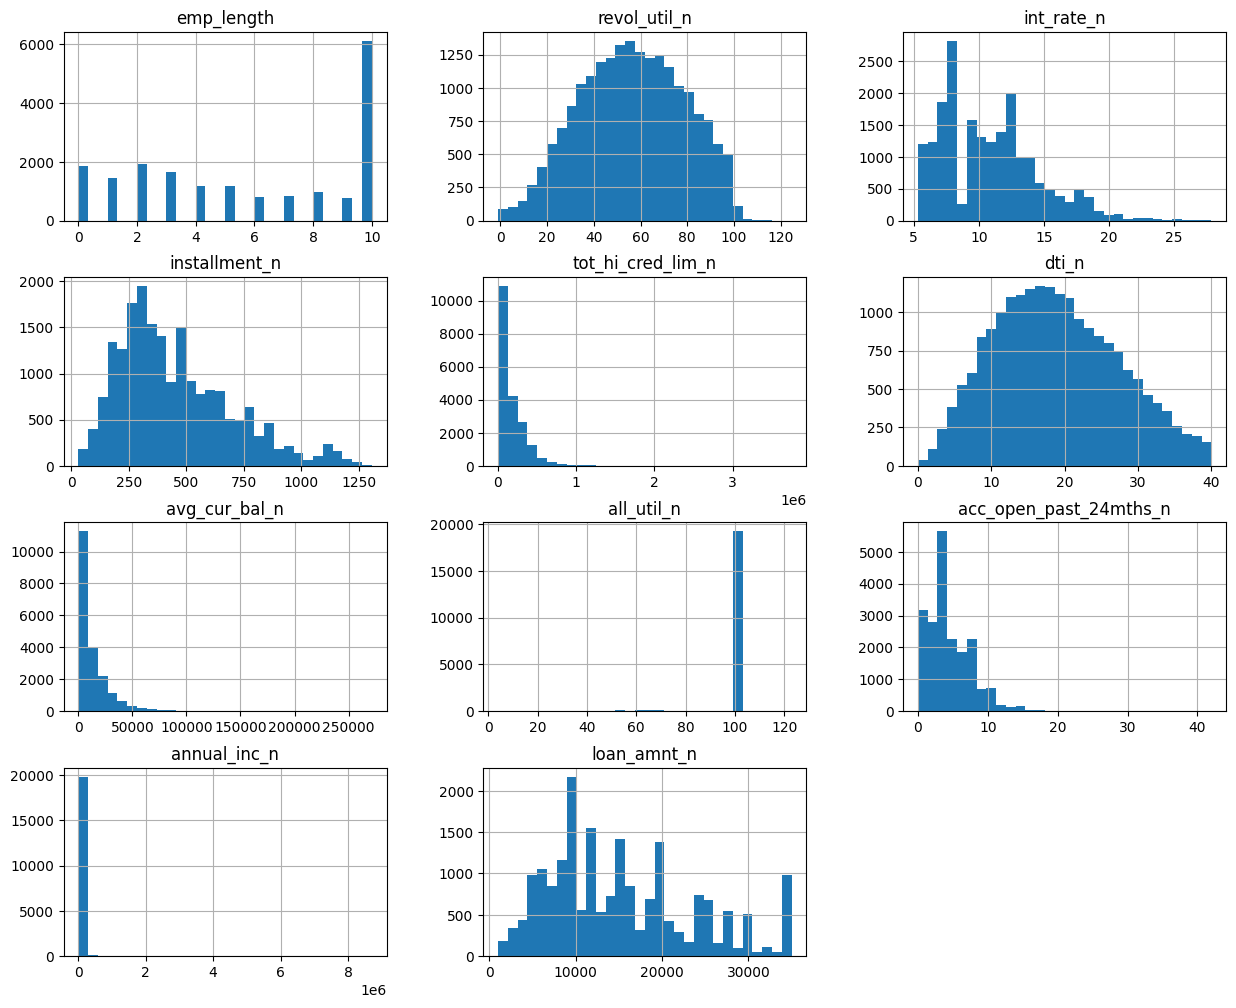

In [98]:
# Distribution plots for numerical features (excluding issue year)
num_cols = [col for col in df_train.select_dtypes(include='number').columns if col != 'issue_y']
df_train[num_cols].hist(figsize=(15, 12), bins=30)
plt.show()

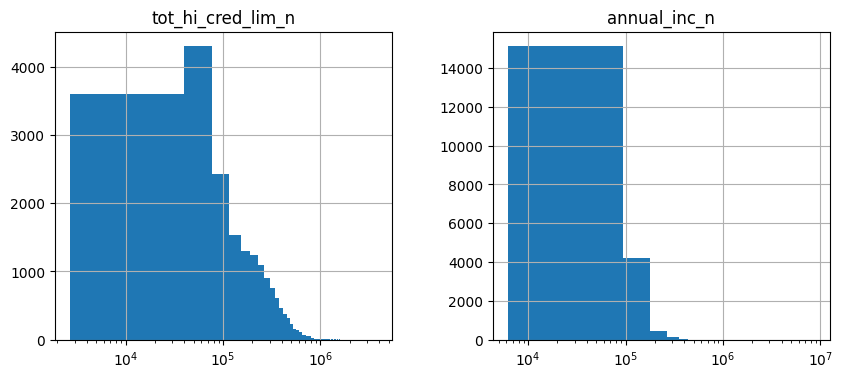

In [99]:
# These 2 variables may have outliers
axes = df_train[['tot_hi_cred_lim_n', 'annual_inc_n']].hist(bins=100, figsize=(10, 4))
for ax in axes.flatten():
    ax.set_xscale('log')
# plt.tight_layout()
plt.show()

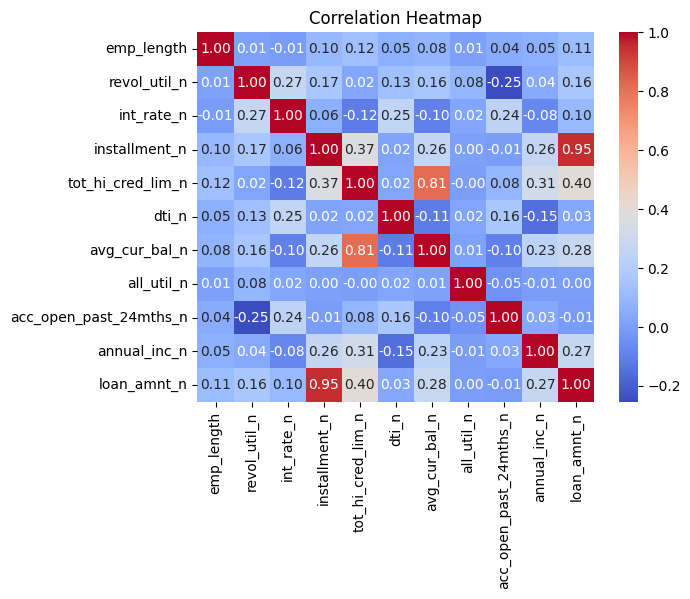

In [100]:
# Correlation map
# plt.figure(figsize=(12, 10))
sns.heatmap(df_train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [102]:
# impute employee length using KNN

# imputer = KNNImputer(n_neighbors=5)
# df_train[['emp_length_n_new']] = imputer.fit_transform(df_train[['emp_length_n']])

# diff_mask = df_train['emp_length_n'] != df_train['emp_length_n_new']
# differences = df_train.loc[diff_mask, ['emp_length_n', 'emp_length_n_new']]
# print(differences)

# KNN imputer imputed missing values with 5.72, we should rather impute it with median 6 

df_train['emp_length'].fillna(df_train['emp_length'].median(), inplace=True)

In [103]:
print("\nMissing Values:\n", df_train['emp_length'].isnull().sum())


Missing Values:
 0


In [104]:
# Create Outcome variable 
df_train['Outcome'] = df_train['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)'] else 0)
print(df_train['Outcome'].value_counts())
print(df_train['Outcome'].value_counts(normalize=True))

Outcome
0    16401
1     3599
Name: count, dtype: int64
Outcome
0    0.82005
1    0.17995
Name: proportion, dtype: float64


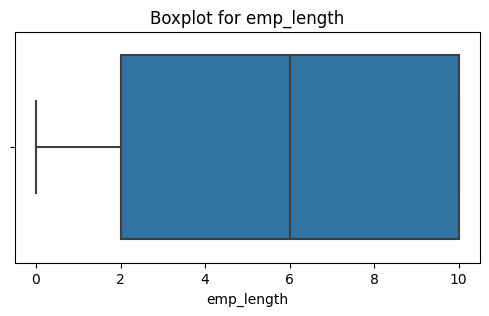

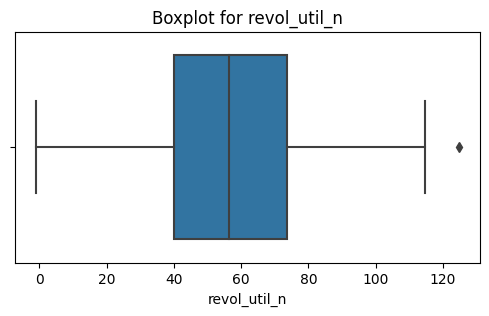

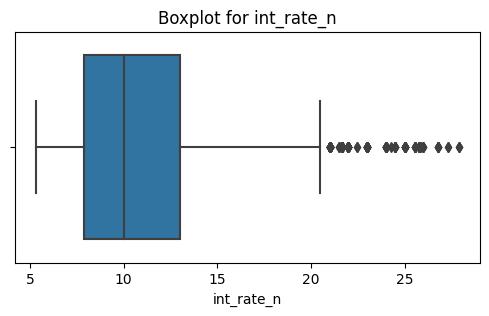

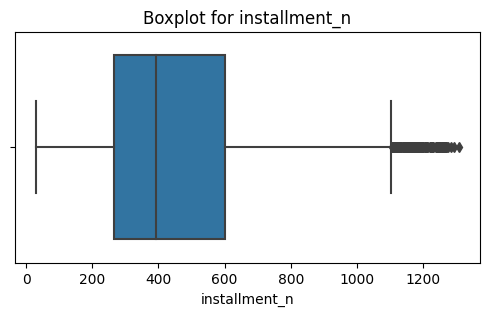

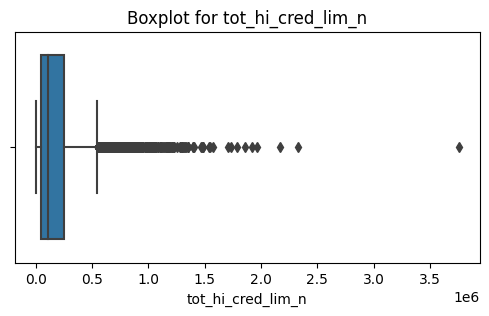

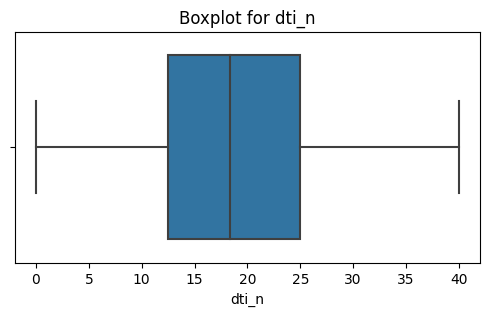

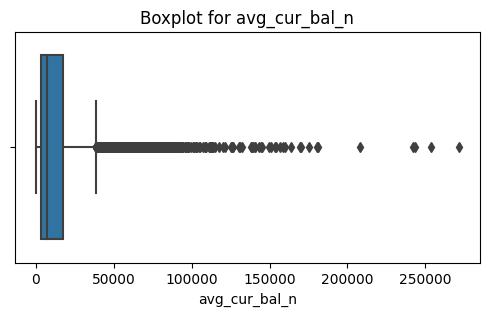

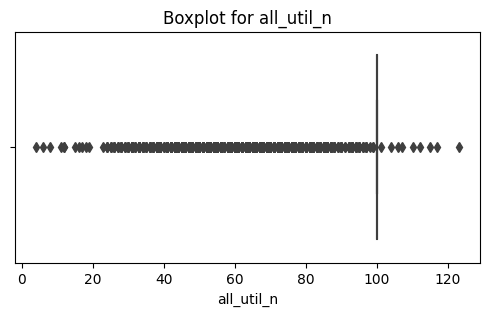

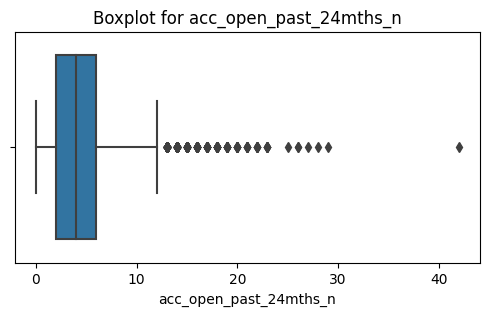

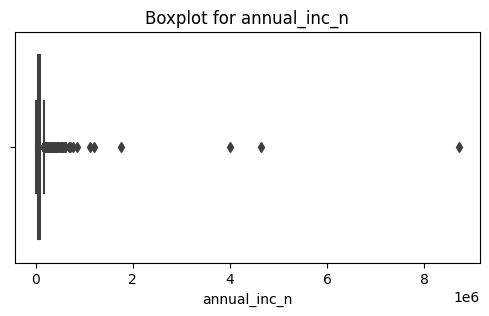

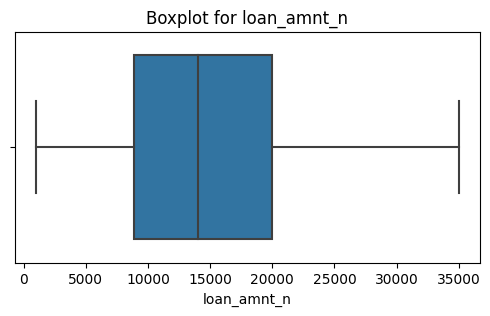

emp_length                   0
revol_util_n                 1
int_rate_n                 251
installment_n              398
tot_hi_cred_lim_n          763
dti_n                        0
avg_cur_bal_n             1262
all_util_n                 773
acc_open_past_24mths_n     397
annual_inc_n               947
loan_amnt_n                  0
dtype: int64


In [105]:
# Check for outliers
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

# Outlier detection using IQR
Q1 = df_train[num_cols].quantile(0.25)
Q3 = df_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_train[num_cols] < (Q1 - 1.5 * IQR)) | (df_train[num_cols] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

In [ ]:
# Encode categorical variables
le_grade = LabelEncoder()
df_train['grade'] = le_grade.fit_transform(df_train['grade'])

le_subgrade = LabelEncoder()
df_train['sub_grade'] = le_subgrade.fit_transform(df_train['sub_grade'])